### Your job is to create statistical models to predict agent days on the market (adom), which is essentially the number of days it took to close the sale from the date of listing, and the sale price of a home (pricesold) based on relevant attributes in this data set.

In [52]:
# Load my toolbox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import plotly.io as pio
from sklearn.model_selection import train_test_split
from stargazer.stargazer import Stargazer
from IPython.core.display import display, HTML
from scipy.stats import shapiro, bartlett
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, bartlett


/var/folders/z9/4yg2bxhd77z407m0mn8rmkdr0000gn/T/ipykernel_72164/2455215602.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Import And Clean the Data

In [53]:
# Import data
df = pd.read_excel("hg_sales_v2.xlsx", sheet_name="Data")

In [54]:
# Make all column header lower case
df.columns = df.columns.str.lower()

# Rename columns
df.rename(columns={'slnoskm': 'house_id'}, inplace=True)
df.rename(columns={'adom_agentdaysonmarket': 'adom'}, inplace=True)
df.rename(columns={'cdom_cumuldaysmls': 'cdom'}, inplace=True)


# Combine baths full and half baths
df['baths'] = df['bathsfull'] + (df['bathshalf'] * 0.5)

# Drop un-needed columns
df.drop(columns=['status', 'address', 'bathsfull', 'bathshalf', 'bathstotal', 'spa', 'subdivn', 'splsale', 'house_id'], inplace=True)

In [55]:
# Standardize pool values: 0 = Yes (Has a private pool), 1 = No (Either no pool or community)
df['pool'] = df['pool'].replace({
    'Private, Community': 0,  # Has a pool
    'Private': 0,             # Has a pool
    'Community': 1,           # No private pool
    'None': 1                 # No pool
}).fillna(1)  # If NaN, assume no pool (1)

# One-hot encode pool (drop_first=True to prevent multicolinearity)
df = pd.get_dummies(df, columns=['pool'], drop_first=True)

/var/folders/z9/4yg2bxhd77z407m0mn8rmkdr0000gn/T/ipykernel_72164/3041218603.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['pool'] = df['pool'].replace({


In [56]:
# Standardize roof types to 'Shingle' and 'Tile', all others dropped
df['roof'] = df['roof'].replace({
    'Concrete, Tile': 'Tile',
    'Tile': 'Tile',
    'Shake, Shingle': 'Shingle',
    'Shingle': 'Shingle'
})
# Keep only Shingle and Tile roof types
df = df[df['roof'].isin(['Tile', 'Shingle'])]

# Convert to binary: Tile=1, Shingle=0
df['roof'] = df['roof'].map({'Tile': 1, 'Shingle': 0})

In [57]:
# Fill empty 'garage' values with mode
df['garages'].fillna(df['garages'].mode()[0], inplace=True)

# Convert boolean columns to integers
df = df.astype({col: int for col in df.select_dtypes(include=['bool']).columns})

/var/folders/z9/4yg2bxhd77z407m0mn8rmkdr0000gn/T/ipykernel_72164/4042428475.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['garages'].fillna(df['garages'].mode()[0], inplace=True)


### Feature engineering

In [58]:
# Ensure 'pendingdate' and 'datesold' are categorized as date/time dtypes 
df['datesold'] = pd.to_datetime(df['datesold'])
df['pendingdate'] = pd.to_datetime(df['pendingdate'])

# Create 'sale_dur' (The date it sold - The date it went on the market) > 0
df['sale_dur'] = (df['datesold'] - df['pendingdate']).dt.days.astype(int)
df = df[df['sale_dur'] >= 0]

# Drop datecolumns to avoid erros with misinterpreted dates and time
df.drop(columns=['datesold', 'pendingdate'], inplace=True)

### Feature selection

In [59]:
# Features selection (PRICE)
# Model 1 (price)
price_feature_1 = ['listprice'] 
# Model 2 (price)
price_feature_2 = ['listprice', 'sqft', 'lotsqft', 'baths', 'lppersqft', 'sppersqft']
# Model 3 (price)
price_feature_3 = ['listprice', 'sqft', 'lotsqft', 'baths', 'lppersqft', 'sppersqft', 'garages', 'beds', 'roof', 'pool_1.0', 'cdom', 'yrblt']

# Features selection (ADOM)
# Model 1 (adom)
adom_feature_1 = ['cdom']
# Model 2 (adom)
adom_feature_2 = ['cdom', 'sqft', 'listprice', 'lotsqft', 'baths', 'beds']
# Model 3 (adom)
adom_feature_3 = ['cdom', 'sqft', 'listprice', 'lotsqft', 'baths', 'beds', 'yrblt', 'roof', 'garages', 'pool_1.0', 'sppersqft', 'lppersqft']

The following tables is used to summarize the hypothesized effects of key predictors on sale price ('pricesold') and days on market ('adom') These variables were selected based on their presumed economic relevance and real estate market intuition,, such as it is. For example, list price is expected to have a strong positive correlation with sale price, while cumulative days on market ('cdom') is expected to extend the time a house is listed.

In [60]:
# Hypothesis table for pricesold Model
hypothesis_price = pd.DataFrame({
    "Predictor": price_feature_3,
    "Hypothesized Effect": ["+", "+", "+", "+", "+", "+", "+", "+", "-", "-", "-", "-"],
    "Rationale": [
        "Higher listing price leads to higher sale price",
        "Larger square footage increases home value",
        "Larger lot size tends to increase home value",
        "More bathrooms generally increase home value",
        "Listing price per square foot impacts pricing",
        "Sale price per square foot directly determines total sale price",
        "Garages provide additional value to buyers",
        "More bedrooms generally increase home value",
        "Roof type impacts maintenance costs and desirability",
        "Having a private pool can decrease demand due to maintenance costs",
        "Cumulative days on market affects negotiation power",
        "Older homes may have lower prices due to aging infrastructure"
    ]
})

# Hypothesis table for adom Model
hypothesis_adom = pd.DataFrame({
    "Predictor": adom_feature_3,
    "Hypothesized Effect": ["+", "-", "+", "-", "-", "-", "+", "+", "-", "+", "+", "+"],
    "Rationale": [
        "Higher cumulative days means longer agent days on market",
        "Larger homes might sell faster due to demand",
        "Higher list price might lead to longer time on market",
        "Bigger lots may attract buyers faster",
        "More bathrooms can improve home desirability",
        "More bedrooms could slow sales if layout is inefficient",
        "Older homes may take longer to sell",
        "Roof quality influences buyer confidence",
        "Garages provide extra value, shortening market time",
        "Having a private pool can deter buyers",
        "Sale price per square foot impacts home perception",
        "Listing price per square foot can determine competitiveness"
    ]
})

# Display hypothesis tables
display(hypothesis_price)
display(hypothesis_adom)

,Predictor,Hypothesized Effect,Rationale
0,listprice,+,Higher listing price leads to higher sale price
1,sqft,+,Larger square footage increases home value
2,lotsqft,+,Larger lot size tends to increase home value
3,baths,+,More bathrooms generally increase home value
4,lppersqft,+,Listing price per square foot impacts pricing
5,sppersqft,+,Sale price per square foot directly determines...
6,garages,+,Garages provide additional value to buyers
7,beds,+,More bedrooms generally increase home value
8,roof,-,Roof type impacts maintenance costs and desira...
9,pool_1.0,-,Having a private pool can decrease demand due ...


,Predictor,Hypothesized Effect,Rationale
0,cdom,+,Higher cumulative days means longer agent days...
1,sqft,-,Larger homes might sell faster due to demand
2,listprice,+,Higher list price might lead to longer time on...
3,lotsqft,-,Bigger lots may attract buyers faster
4,baths,-,More bathrooms can improve home desirability
5,beds,-,More bedrooms could slow sales if layout is in...
6,yrblt,+,Older homes may take longer to sell
7,roof,+,Roof quality influences buyer confidence
8,garages,-,"Garages provide extra value, shortening market..."
9,pool_1.0,+,Having a private pool can deter buyers


### Train_Test_Split

In [61]:
# Define target variables
y_price = df['pricesold']
y_adom = df['adom']

# Split data into train/test sets (80% train, 20% test)
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(df[price_feature_3], y_price, test_size=0.2, random_state=42)
X_train_adom, X_test_adom, y_train_adom, y_test_adom = train_test_split(df[adom_feature_3], y_adom, test_size=0.2, random_state=42)

### Train OLS Models

In [62]:
# Fit models
model_price_1 = sm.OLS(y_train_price, sm.add_constant(X_train_price[price_feature_1])).fit()
model_price_2 = sm.OLS(y_train_price, sm.add_constant(X_train_price[price_feature_2])).fit()
model_price_3 = sm.OLS(y_train_price, sm.add_constant(X_train_price[price_feature_3])).fit()

model_adom_1 = sm.OLS(y_train_adom, sm.add_constant(X_train_adom[adom_feature_1])).fit()
model_adom_2 = sm.OLS(y_train_adom, sm.add_constant(X_train_adom[adom_feature_2])).fit()
model_adom_3 = sm.OLS(y_train_adom, sm.add_constant(X_train_adom[adom_feature_3])).fit()


### Display Regression Results Using Stargazer

In [63]:
stargazer_price = Stargazer([model_price_1, model_price_2, model_price_3])
stargazer_adom = Stargazer([model_adom_1, model_adom_2, model_adom_3])

display(HTML(stargazer_price.render_html()))
display(HTML(stargazer_adom.render_html()))



=== Assumption Tests for Final Price Model ===


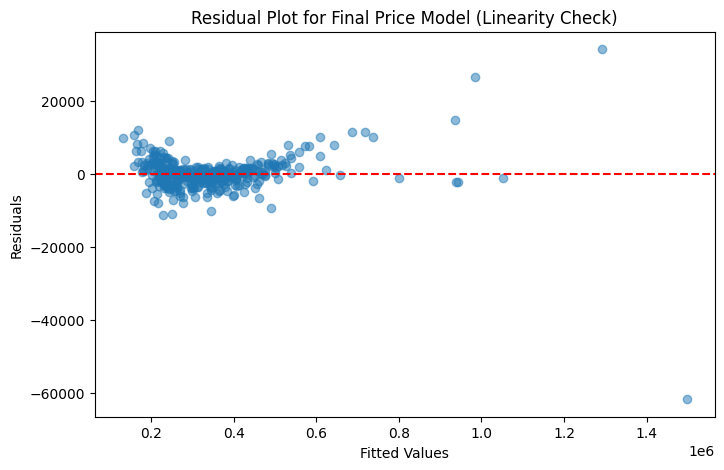

Normality (Shapiro-Wilk p-value): 0.00000
Homoscedasticity (Bartlett p-value): 0.00000
Independence (Durbin-Watson statistic): 1.997

VIF Scores:
      Feature            VIF
0       const  751391.781041
1   listprice      51.475077
2        sqft      35.288453
3     lotsqft       3.482682
4       baths       4.338708
5   lppersqft      43.707886
6   sppersqft      28.823009
7     garages       2.014804
8        beds       2.129685
9        roof       1.538149
10   pool_1.0       1.689680
11       cdom       1.353675
12      yrblt       1.286152

=== Assumption Tests for Final Adom Model ===


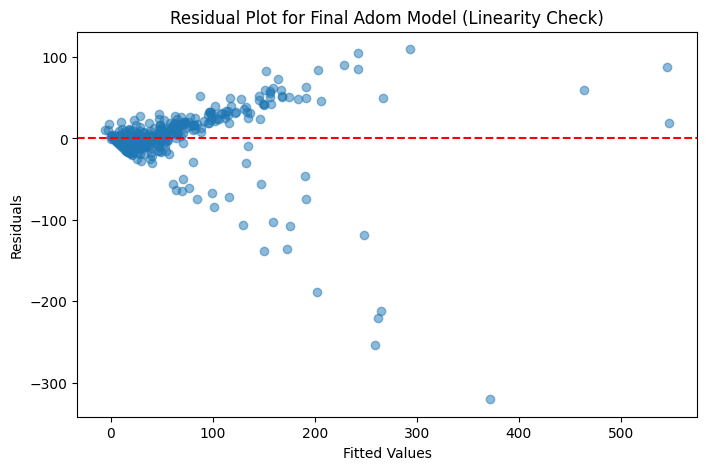

Normality (Shapiro-Wilk p-value): 0.00000
Homoscedasticity (Bartlett p-value): 0.00000
Independence (Durbin-Watson statistic): 1.963

VIF Scores:
      Feature            VIF
0       const  751391.781041
1        cdom       1.353675
2        sqft      35.288453
3   listprice      51.475077
4     lotsqft       3.482682
5       baths       4.338708
6        beds       2.129685
7       yrblt       1.286152
8        roof       1.538149
9     garages       2.014804
10   pool_1.0       1.689680
11  sppersqft      28.823009
12  lppersqft      43.707886


In [64]:
def regression_assumptions(model, X_train, y_train, model_name):
    print(f"\n=== Assumption Tests for {model_name} ===")

    # 1. Linearity Check - Residuals vs Fitted Values
    plt.figure(figsize=(8, 5))
    plt.scatter(model.fittedvalues, model.resid, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {model_name} (Linearity Check)")
    plt.show()
    # If the points in the residual plot display a clear pattern (e.g., a curve), then the assumption of linearity is violated.

    
    # 2. Normality (Shapiro-Wilk Test)
    shapiro_test = shapiro(model.resid)
    print(f"Normality (Shapiro-Wilk p-value): {shapiro_test.pvalue:.5f}")
    # The normality assumption states that the residuals of the model should follow a normal distribution

    # 3. Homoscedasticity (Bartlett Test)
    bartlett_test = bartlett(model.resid, model.fittedvalues)
    print(f"Homoscedasticity (Bartlett p-value): {bartlett_test.pvalue:.5f}")
    # Homoscedasticity means that the variance of residuals should be constant across all levels of independent variables

    # 4. Independence (Durbin-Watson Test)
    dw_test = durbin_watson(model.resid)
    print(f"Independence (Durbin-Watson statistic): {dw_test:.3f}")
    # The Durbin-Watson test checks for autocorrelation in residuals, with values close to 2.0 indicating no significant autocorrelation

    # 5. Multicollinearity (VIF)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_train.columns
    vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    print("\nVIF Scores:")
    print(vif_data)
    # VIF measures how much an independent variable is correlated with others. A VIF above 10 indicates severe multicollinearity

# Define X_train variables correctly
X_price_3 = sm.add_constant(X_train_price[price_feature_3])
X_adom_3 = sm.add_constant(X_train_adom[adom_feature_3])

# Run assumption tests for best models
regression_assumptions(model_price_3, X_price_3, y_price, "Final Price Model")
regression_assumptions(model_adom_3, X_adom_3, y_adom, "Final Adom Model")

### -----Apply Log Transformations-----

In [65]:
# Add log transformation at the end of the code
df['log_pricesold'] = np.log(df['pricesold'])
df['log_adom'] = np.log(df['adom'])

print("\n Log-transformed variables added: 'log_pricesold' and 'log_adom'")

# Train-test split for log-transformed dependent variables
X_train_log_price, X_test_log_price, y_train_log_price, y_test_log_price = train_test_split(
    df[price_feature_3], df['log_pricesold'], test_size=0.2, random_state=42
)

X_train_log_adom, X_test_log_adom, y_train_log_adom, y_test_log_adom = train_test_split(
    df[adom_feature_3], df['log_adom'], test_size=0.2, random_state=42
)

print("\n Train-test split completed for log-transformed models.")


 Log-transformed variables added: 'log_pricesold' and 'log_adom'

 Train-test split completed for log-transformed models.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [66]:
# Fit log-transformed models for pricesold
X_log_price_1 = sm.add_constant(X_train_log_price[price_feature_1])
X_log_price_2 = sm.add_constant(X_train_log_price[price_feature_2])
X_log_price_3 = sm.add_constant(X_train_log_price[price_feature_3])

model_log_price_1 = sm.OLS(y_train_log_price, X_log_price_1).fit()
model_log_price_2 = sm.OLS(y_train_log_price, X_log_price_2).fit()
model_log_price_3 = sm.OLS(y_train_log_price, X_log_price_3).fit()

# Fit log-transformed models for adom
X_log_adom_1 = sm.add_constant(X_train_log_adom[adom_feature_1])
X_log_adom_2 = sm.add_constant(X_train_log_adom[adom_feature_2])
X_log_adom_3 = sm.add_constant(X_train_log_adom[adom_feature_3])

model_log_adom_1 = sm.OLS(y_train_log_adom, X_log_adom_1).fit()
model_log_adom_2 = sm.OLS(y_train_log_adom, X_log_adom_2).fit()
model_log_adom_3 = sm.OLS(y_train_log_adom, X_log_adom_3).fit()

print("\n Log-transformed regression models fitted.")


 Log-transformed regression models fitted.


In [67]:
# Stargazer tables for log-transformed price models
stargazer_log_price = Stargazer([model_log_price_1, model_log_price_2, model_log_price_3])
stargazer_log_price.title("Regression Results for Log-Transformed Pricesold")
stargazer_log_price.significant_digits(3)

# Stargazer tables for log-transformed adom models
stargazer_log_adom = Stargazer([model_log_adom_1, model_log_adom_2, model_log_adom_3])
stargazer_log_adom.title("Regression Results for Log-Transformed Adom")
stargazer_log_adom.significant_digits(3)

# Display original vs. log-transformed models
print("\n Displaying Stargazer tables for log-transformed models:")
display(HTML(stargazer_log_price.render_html()))
display(HTML(stargazer_log_adom.render_html()))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1733: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1733: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)



 Displaying Stargazer tables for log-transformed models:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1733: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)



 Running assumption tests for log-transformed models:

=== Assumption Tests for Log-Transformed Price Model ===


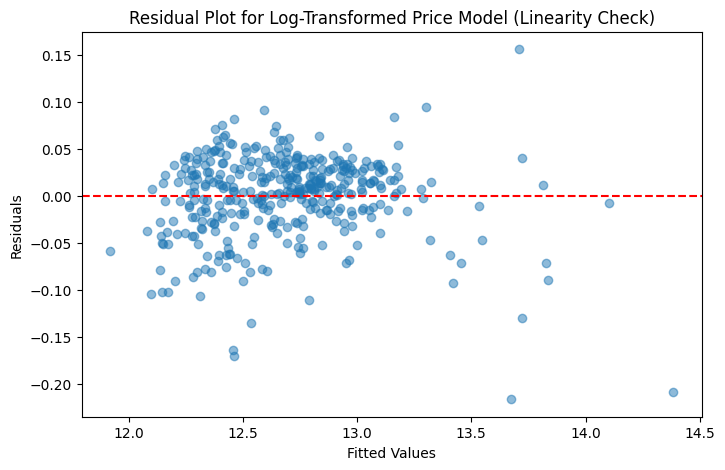

Normality (Shapiro-Wilk p-value): 0.00000
Homoscedasticity (Bartlett p-value): 0.00000
Independence (Durbin-Watson statistic): 1.996

VIF Scores:
      Feature            VIF
0       const  751391.781041
1   listprice      51.475077
2        sqft      35.288453
3     lotsqft       3.482682
4       baths       4.338708
5   lppersqft      43.707886
6   sppersqft      28.823009
7     garages       2.014804
8        beds       2.129685
9        roof       1.538149
10   pool_1.0       1.689680
11       cdom       1.353675
12      yrblt       1.286152

=== Assumption Tests for Log-Transformed Adom Model ===


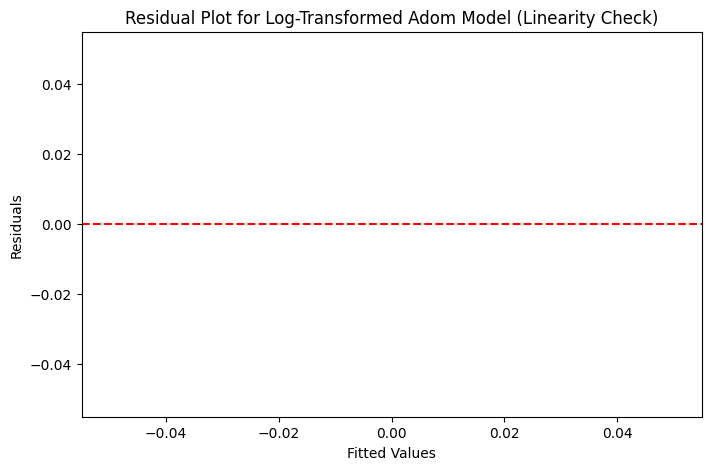

Normality (Shapiro-Wilk p-value): nan
Homoscedasticity (Bartlett p-value): nan
Independence (Durbin-Watson statistic): nan

VIF Scores:
      Feature            VIF
0       const  751391.781041
1        cdom       1.353675
2        sqft      35.288453
3   listprice      51.475077
4     lotsqft       3.482682
5       baths       4.338708
6        beds       2.129685
7       yrblt       1.286152
8        roof       1.538149
9     garages       2.014804
10   pool_1.0       1.689680
11  sppersqft      28.823009
12  lppersqft      43.707886


In [68]:
# Run assumption tests for log-transformed models
print("\n Running assumption tests for log-transformed models:")

regression_assumptions(model_log_price_3, X_log_price_3, y_train_log_price, "Log-Transformed Price Model")
regression_assumptions(model_log_adom_3, X_log_adom_3, y_train_log_adom, "Log-Transformed Adom Model")

### ||-------------------------------|| End of Assignment ||-------------------------------||